# Multi-Armed Bandit

Written by [Junkun Yuan](https://junkunyuan.github.io/) (yuanjk0921@outlook.com).

See paper reading list and notes [here](https://junkunyuan.github.io/paper_reading_list/paper_reading_list.html).

Last updated on Aug 31, 2025; &nbsp; First committed on Aug 31, 2025.

**References**

- [**Hands-on RL**](https://github.com/boyu-ai/Hands-on-RL/blob/main/%E7%AC%AC2%E7%AB%A0-%E5%A4%9A%E8%87%82%E8%80%81%E8%99%8E%E6%9C%BA%E9%97%AE%E9%A2%98.ipynb): implementation.
- [**An Empirical Evaluation of Thompson Sampling** *(NeurIPS 2011)*](https://proceedings.neurips.cc/paper/2011/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf): ε-greedy, Decaying ε-Greedy, UCB.
- [**Finite-time Analysis of the Multiarmed Bandit Problem** *(Machine Learning 2002)*](https://link.springer.com/content/pdf/10.1023/a:1013689704352.pdf): Thompson Sampling.


**Contents**
- Multi-Armed Bandit
- ε-greedy
- Decaying ε-Greedy
- Upper Confidence Bound (UCB)
- Thompson Sampling
- Cumulative Regret Comparisons

## Multi-Armed Bandit

**Task.** Multi-armed bandit (MAB) is a decision-making problem where an agent choose among multiple options (arms) with uncertain rewards to maximize cumulative gain over time.

**Action.** Let $K$ be the action space (the number of arms), action set is $\mathcal{A}=\{a^1, ..., a^K\}$.

**Reward.** Reward distribution of each action is $\mathcal{R}(r|a)$. At timestep $t$, the agent takes action $a_t$ and gets reward $r_t\sim \mathcal{R}(\cdot|a_t)$.

**Expected reward.** For each action $a$, its expected reward $Q(a)=\mathbb{E}_{r\sim \mathcal{R}(\cdot|a)}[r]$. The expected reward of the optimal action is $Q^*=\max_{a\in\mathcal{A}}Q(a)$.

**Regret.** Regret is the error of current action: $R(a)=Q^*-Q(a)$.

**Goal.** The goal of MAB is to maximize the cumulative reward: $\max\sum_{t=1}^T r_t$. In other words, to minimize the cumulative regret: $\sigma_R=\sum_{t=1}^{T}R(a_t)$.

**Basic idea.** The way to solve MAB is to balance the exploration, i.e., try more arms, and exploitation, i.e., use the arm with the largest expected reward. 

In [1]:
## --------------------------------------------------------------------------------
## Build Multi-Armed Bandit
## --------------------------------------------------------------------------------
import numpy as np

SEED = 2025
np.random.seed(SEED)

class BernoulliBandit:
    """Build a Bernoulli bandit, input K as the number of arms"""
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # the probability of winning
        self.best_idx = np.argmax(self.probs)  # the arm with the highest winning probability
        self.best_prob = self.probs[self.best_idx]  # the highest winning probability
        self.K = K

    def step(self, k):
        # When the player selects the k-th arm, return 1 (winning) or 0 (not winning)
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

K = 10
bandit_10_arm = BernoulliBandit(K=K)
print("A Bernoulli bandit with %d arms is generated" % K)
print("The arm with the highest winning probability is %d, and its winning probability is %.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))
## --------------------------------------------------------------------------------

A Bernoulli bandit with 10 arms is generated
The arm with the highest winning probability is 8, and its winning probability is 0.9642


In [2]:
## --------------------------------------------------------------------------------
## Basic Algorithm Framework
## --------------------------------------------------------------------------------
class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # the number of times each arm is pulled
        self.regret = 0.
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        # Calculate the cumulative regret, k is the selected arm
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # Return the selected arm, to be implemented by each specific strategy
        raise NotImplementedError

    def run(self, num_steps):
        # Run for a certain number of times, num_steps is the total number of runs
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)
## --------------------------------------------------------------------------------

## ε-greedy

It balances exploration and exploitation by choosing a random action with probability ε, i.e., $a_t\sim U(\{a_1, ..., a_K\})$, and the current best-known action with probability 1-ε, i.e., $a_t=\arg\max_{a\in\mathcal{A}}\hat{Q}(a)$.

In [3]:
## --------------------------------------------------------------------------------
## ε-Greedy Algorithm
## --------------------------------------------------------------------------------
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)  # expected reward estimates

    def run_one_step(self):
        ## Randomly select an arm with probability epsilon
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        ## Otherwise, choose the arm with the highest estimated reward
        else:
            k = np.argmax(self.estimates)

        ## Get reward and update the estimated reward
        r = self.bandit.step(k)
        ## Below equals to: estimates[k] = ((estimates[k] * counts[k]) + r) / (counts[k] + 1)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        
        return k

epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01, init_prob=1.0)
epsilon_greedy_solver.run(5000)
print(f"Cumulative regret: {epsilon_greedy_solver.regret}")
## --------------------------------------------------------------------------------

Cumulative regret: 18.812234986805716


## Decaying ε-Greedy

It gradually decreases ε over time so that the agent explores more in the beginning and increasingly exploits the best-known action as learning progresses.

In [4]:
## --------------------------------------------------------------------------------
## Decaying ε-Greedy
## --------------------------------------------------------------------------------
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon decays with time
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print(f"Cumulative regret: {decaying_epsilon_greedy_solver.regret}")
## --------------------------------------------------------------------------------

Cumulative regret: 8.381550539226824


## Upper Confidence Bound (UCB)

It selects the action that maximizes its estimated reward and an exploration bonus proportional to the uncertainty, balancing exploration and exploitation.

Specifically, the estimated uncertainty is $\hat{U}_t(a)=\sqrt{\frac{\log t}{2(N_t(a)+1)}}$. Then, $a_t=\arg\max_{a\in\mathcal{A}}\hat{Q}(a) + c\cdot\hat{U}(a)$ where $c$ is a hyper-parameter.

In [5]:
## --------------------------------------------------------------------------------
## Upper Confidence Bound (UCB)
## --------------------------------------------------------------------------------
class UCB(Solver):
    def __init__(self, bandit, coef=1.0, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

UCB_solver = UCB(bandit_10_arm, coef=1.0, init_prob=1.0)
UCB_solver.run(5000)
print(f"Cumulative regret: {UCB_solver.regret}")
## --------------------------------------------------------------------------------

Cumulative regret: 85.36436726317973


## Thompson Sampling

It chooses actions by sampling from the posterior distribution of each action's reward probability (estimated), balancing exploration and exploitation in a Bayesian manner.

In [6]:
## --------------------------------------------------------------------------------
## Thompson Sampling
## --------------------------------------------------------------------------------
class ThompsonSampling(Solver):
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # the number of reward=1 of each arm
        self._b = np.ones(self.bandit.K)  # the number of reward=0 of each arm

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # sample from posterior distribution
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += (1 - r)
        return k

thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print(f"Cumulative regret: {thompson_sampling_solver.regret}")
## --------------------------------------------------------------------------------

Cumulative regret: 31.432341056769136


## Cumulative Regret Comparisons

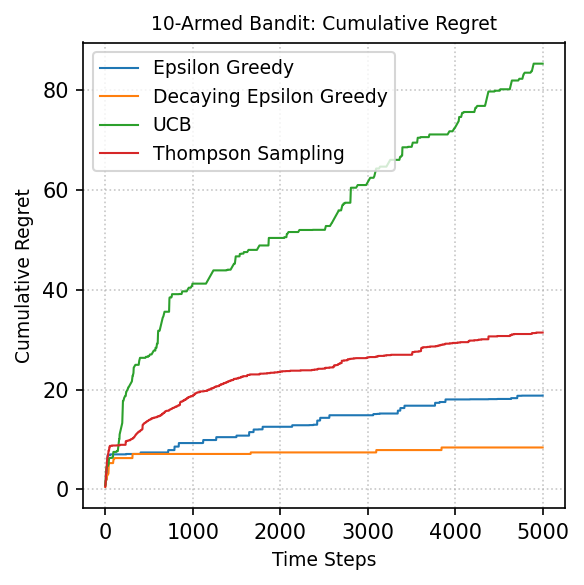

In [7]:
## --------------------------------------------------------------------------------
## Plot Results
## --------------------------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_results(solvers, solver_names, fontsize=9):
    """Simple plot of cumulative regret over time for each solver."""
    plt.figure(figsize=(4, 4), dpi=150)  # smaller size, higher resolution
    for solver, name in zip(solvers, solver_names):
        plt.plot(solver.regrets, label=name, linewidth=1)
    plt.xlabel('Time Steps', fontsize=fontsize)
    plt.ylabel('Cumulative Regret', fontsize=fontsize)
    plt.title(f"{solvers[0].bandit.K}-Armed Bandit: Cumulative Regret", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

solvers = [epsilon_greedy_solver, decaying_epsilon_greedy_solver, UCB_solver, thompson_sampling_solver]
solver_names = ["Epsilon Greedy", "Decaying Epsilon Greedy", "UCB", "Thompson Sampling"]
plot_results(solvers, solver_names)
## --------------------------------------------------------------------------------